# 0. Install and Import Dependencies

In [91]:
!pip install opencv-python-headless matplotlib imageio gdown tensorflow

In [92]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [93]:
tf.config.list_physical_devices('GPU')

[]

In [94]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [95]:
import gdown

In [96]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=39888454-65c6-4cc2-b35d-c882c97d1259
To: /home/shashank/data.zip
100%|██████████| 423M/423M [00:07<00:00, 60.4MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [97]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [98]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [99]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [100]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [101]:
char_to_num(['v','e','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([22,  5,  3])>

In [102]:
num_to_char([22,  5,  3])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'v', b'e', b'c'], dtype=object)>

In [103]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [104]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [105]:
test_path = 'data/alignments/s1/bbaf2n.align'


In [106]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbaf2n'

In [107]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [108]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [109]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [110]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [111]:
from matplotlib import pyplot as plt

In [112]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [113]:
len(test)

51

In [114]:
frames, alignments = data.as_numpy_iterator().next()

In [115]:
len(frames)

2

In [116]:
sample = data.as_numpy_iterator()

In [117]:
val = sample.next(); val[0]

array([[[[[ 1.3980935 ],
          [ 1.5114524 ],
          [ 1.2091619 ],
          ...,
          [ 0.3400768 ],
          [ 0.30229047],
          [ 0.30229047]],

         [[ 1.5114524 ],
          [ 1.6625977 ],
          [ 1.2847345 ],
          ...,
          [ 0.3400768 ],
          [ 0.30229047],
          [ 0.30229047]],

         [[ 1.5114524 ],
          [ 1.5114524 ],
          [ 1.3980935 ],
          ...,
          [ 0.3400768 ],
          [ 0.3400768 ],
          [ 0.3400768 ]],

         ...,

         [[ 1.095803  ],
          [ 1.0580167 ],
          [ 1.0580167 ],
          ...,
          [ 0.07557262],
          [ 0.07557262],
          [ 0.07557262]],

         [[ 1.0202304 ],
          [ 1.0202304 ],
          [ 1.0202304 ],
          ...,
          [ 0.07557262],
          [ 0.07557262],
          [ 0.07557262]],

         [[ 1.0202304 ],
          [ 1.0202304 ],
          [ 1.0202304 ],
          ...,
          [ 0.07557262],
          [ 0.07557262],
          

In [118]:

# imageio.mimsave('./animation.gif', val[0][0], fps=10)

In [119]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at m one again'>

# 3. Design the Deep Neural Network

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [121]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [122]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [123]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

 dropout_3 (Dropout)         (None, 75, 256)           0         
                                                                 
 dense_1 (Dense)             (None, 75, 41)            10537     
                                                                 
Total params: 8471924 (32.32 MB)
Trainable params: 8471924 (32.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [125]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666664'>

In [126]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666664'>

In [127]:
model.input_shape

(None, 75, 46, 140, 1)

In [128]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [129]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [130]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)



    return loss

In [131]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [132]:
# from tensorflow.keras.optimizers import Adam as LegacyAdam
from tensorflow.keras.optimizers.legacy import Adam as NewAdam
model.compile(optimizer=NewAdam(learning_rate=0.0001), loss=CTCLoss)

# Load weights before starting the training
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

checkpoint_path = "models/checkpoint"
model.load_weights(checkpoint_path)


# model.compile(optimizer=LegacyAdam(learning_rate=0.0001), loss=CTCLoss)

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=6c99a2c9-915c-4f65-a61a-4a2a35bf32a5
To: /home/shashank/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 48.3MB/s]


In [133]:
# Set up callbacks
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [134]:
# Start training
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

450/450 [==============================] - ETA: 0s - loss: 3.0252

[mpeg1video @ 0x7f25b0016200] ac-tex damaged at 22 17
[mpeg1video @ 0x7f25b0016200] Warning MVs not available
[mpeg1video @ 0x7f268c008c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f268c008c80] Warning MVs not available
[mpeg1video @ 0x7f2330180740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f2330180740] Warning MVs not available


1/1 [==============================] - 7s 7s/step
Original: place green at q nine again
Prediction: place gren at q nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with u five soon
Prediction: set blue with u five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 2569s 6s/step - loss: 3.0252 - val_loss: 1.0866 - lr: 3.0197e-06


In [135]:
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [136]:
# model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [137]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [138]:
model.load_weights('models/checkpoint')

In [139]:
test_data = test.as_numpy_iterator()

In [140]:
sample = test_data.next()

[mpeg1video @ 0x7f276800ad40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f276800ad40] Warning MVs not available


In [141]:
yhat = model.predict(sample[0])

1/1 [==============================] - 1s 864ms/step


In [142]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place sp blue at i six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green at s five again'>]

In [143]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [144]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place pblue at i six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green at s five again'>]

# Test on a Video

In [145]:
def custom_accuracy(real_sequence, predicted_sequence):
    """
    Calculates the accuracy of the lip reading model by comparing the predicted sequence
    with the actual sequence.

    Args:
        real_sequence (tf.Tensor): A scalar tensor of dtype string representing the actual sequence.
        predicted_sequence (tf.Tensor): A scalar tensor of dtype string representing the predicted sequence.

    Returns:
        float: The accuracy of the model.
    """
    real_words = real_sequence.numpy().decode('utf-8').split()
    pred_words = predicted_sequence.numpy().decode('utf-8').split()

    total_words = len(real_words)
    correct_words = sum(1 for real_word, pred_word in zip(real_words, pred_words) if real_word == pred_word)

    real_sentence_str = ' '.join(real_words)
    pred_sentence_str = ' '.join(pred_words)

    print(f"Real sentence: {real_sentence_str}")
    print(f"Predicted sentence: {pred_sentence_str}")

    accuracy = correct_words / total_words if total_words > 0 else 0.0
    print(f"Overall accuracy: {accuracy * 100:.2f}%")

    return accuracy

In [179]:
def custom_accuracy(real_sequence, predicted_sequence):
    """
    Calculates the accuracy, precision, recall, and F1 score of the lip reading model
    by comparing the predicted sequence with the actual sequence.

    Args:
        real_sequence (tf.Tensor): A scalar tensor of dtype string representing the actual sequence.
        predicted_sequence (tf.Tensor): A scalar tensor of dtype string representing the predicted sequence.

    Returns:
        float: The accuracy of the model.
        float: The precision of the model.
        float: The recall of the model.
        float: The F1 score of the model.
    """
    real_words = real_sequence.numpy().decode('utf-8').split()
    pred_words = predicted_sequence.numpy().decode('utf-8').split()

    total_words = len(real_words)
    correct_words = sum(1 for real_word, pred_word in zip(real_words, pred_words) if real_word == pred_word)
    incorrect_words = total_words - correct_words

    real_sentence_str = ' '.join(real_words)
    pred_sentence_str = ' '.join(pred_words)

    print(f"Real sentence: {real_sentence_str}")
    print(f"Predicted sentence: {pred_sentence_str}")

    accuracy = correct_words / total_words if total_words > 0 else 0.0
    print(f"Overall accuracy: {accuracy * 100:.2f}%")

    tp = correct_words
    fp = incorrect_words
    fn = 0  # Assuming no false negatives for simplicity

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1_score * 100:.2f}%")

    return accuracy, precision, recall, f1_score

In [180]:
a=os.getcwd()
b=os.path.join(a,'data/s1')
file=len(os.listdir(b))
print(file)
acc = []
prec = []
rec = []
f1 = []
for filename in os.listdir(b):
    c = os.path.join(b, filename)
    print("filename", c)
    sample = load_data(tf.convert_to_tensor(c))
    print('~' * 100, 'REAL TEXT')
    actual = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
    print(actual)
    act = actual[0]
    yhat = model.predict(tf.expand_dims(sample[0], axis=0))
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[sample[0].shape[1]], greedy=True)[0][0].numpy()
    print('~' * 100, 'PREDICTIONS')
    predicted = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
    print(predicted)
    pred = predicted[0]
    acc_test, prec_test, rec_test, f1_test = custom_accuracy(act, pred)
    print(acc_test, prec_test, rec_test, f1_test)
    acc.append(acc_test)
    prec.append(prec_test)
    rec.append(rec_test)
    f1.append(f1_test)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

1001
filename /home/shashank/data/s1/bbaf2n.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]
1/1 [==============================] - 0s 458ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]
Real sentence: bin blue at f two now
Predicted sentence: bin blue at f two now
Overall accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
1.0 1.0 1.0 1.0
filename /home/shashank/data/s1/bbaf5a.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]
1/1 [==============================] - 0s 431ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[mpeg1video @ 0x26d0d5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x26d0d5c0] Warning MVs not available


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in b eight now'>]
1/1 [==============================] - 0s 430ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'lay gree it u eg now'>]
Real sentence: set green in b eight now
Predicted sentence: lay gree it u eg now
Overall accuracy: 16.67%
Precision: 16.67%
Recall: 100.00%
F1 Score: 28.57%
0.16666666666666666 0.16666666666666666 1.0 0.2857142857142857
filename /home/shashank/data/s1/sgbv8n.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by v eight now'>]
1/1 [==============================] - 0s 425ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/Thumbs.align'

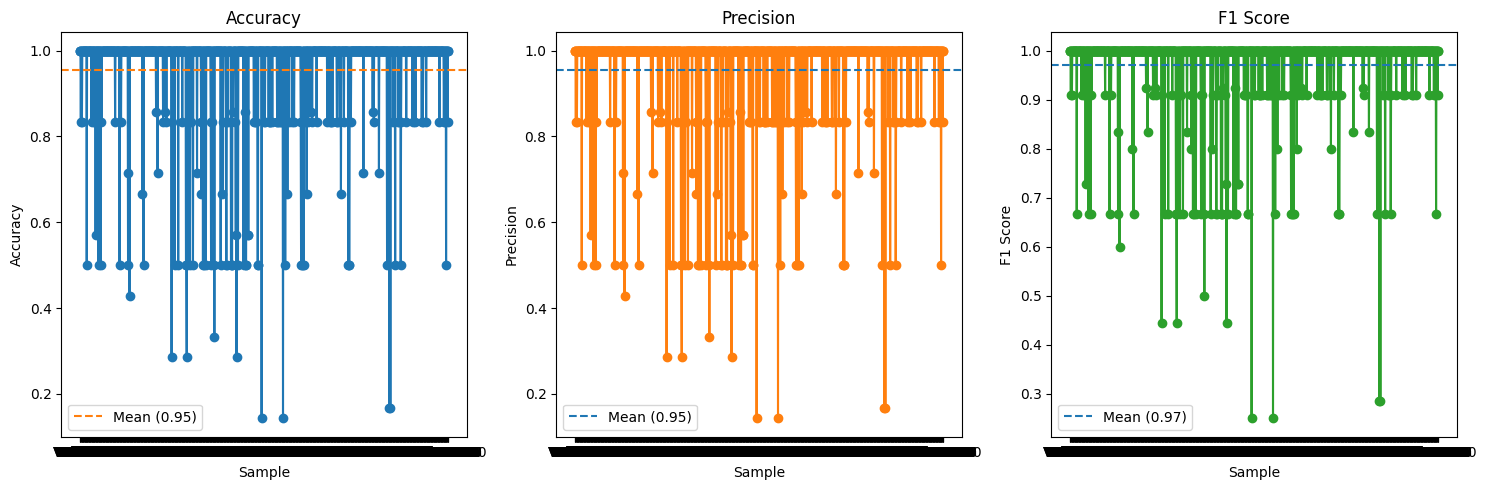

In [191]:
import matplotlib.pyplot as plt

# Calculate means
mean_acc = sum(acc) / len(acc)
mean_prec = sum(prec) / len(prec)
mean_f1 = sum(f1) / len(f1)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define colors
colors = plt.cm.tab10(np.arange(3))

# Plot accuracy
axs[0].plot(acc, linestyle='-', color=colors[0])
axs[0].axhline(mean_acc, color=colors[1], linestyle='--', label=f'Mean ({mean_acc:.2f})')
axs[0].set_xticks(range(len(acc)))
axs[0].set_xticklabels([f'Value {i+1}' for i in range(len(acc))])
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].legend()

# Plot precision
axs[1].plot(prec, linestyle='-', color=colors[1])
axs[1].axhline(mean_prec, color=colors[0], linestyle='--', label=f'Mean ({mean_prec:.2f})')
axs[1].set_xticks(range(len(prec)))
axs[1].set_xticklabels([f'Value {i+1}' for i in range(len(prec))])
axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision')
axs[1].legend()

# Plot F1 score
axs[2].plot(f1, linestyle='-', color=colors[2])
axs[2].axhline(mean_f1, color=colors[0], linestyle='--', label=f'Mean ({mean_f1:.2f})')
axs[2].set_xticks(range(len(f1)))
axs[2].set_xticklabels([f'Value {i+1}' for i in range(len(f1))])
axs[2].set_xlabel('Sample')
axs[2].set_ylabel('F1 Score')
axs[2].set_title('F1 Score')
axs[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [187]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = np.zeros((len(classes), len(classes)), dtype=np.int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[classes.index(true_label), classes.index(pred_label)] += 1

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

# Example usage:
# Assuming y_true and y_pred are lists of actual and predicted labels, and classes is a list of class names
plt.show()


In [148]:
a=os.getcwd()
b=os.path.join(a,'data/s1')
file=len(os.listdir(b))
print(file)
acc=[]
for filename in os.listdir(b):
  c=os.path.join(b,filename)
  print("filename",c)
  sample = load_data(tf.convert_to_tensor(c))
  print('~'*100, 'REAL TEXT')
  actual=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
  print(actual)
  act=actual[0]
  yhat = model.predict(tf.expand_dims(sample[0], axis=0))
  decoded = tf.keras.backend.ctc_decode(yhat, input_length=[sample[0].shape[1]], greedy=True)[0][0].numpy()
  print('~'*100, 'PREDICTIONS')
  predicted=[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
  print(predicted)
  pred=predicted[0]
  acc_test=custom_accuracy(act,pred)
  print(acc_test)
  acc.append(acc_test)



1001
filename /home/shashank/data/s1/bbaf2n.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]
1/1 [==============================] - 0s 439ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]
Real sentence: bin blue at f two now
Predicted sentence: bin blue at f two now
Overall accuracy: 100.00%
1.0
filename /home/shashank/data/s1/bbaf5a.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>]
1/1 [==============================] - 0s 430ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=stri

[mpeg1video @ 0x2898aa80] ac-tex damaged at 22 17
[mpeg1video @ 0x2898aa80] Warning MVs not available


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in b eight now'>]
1/1 [==============================] - 0s 421ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'lay gree it u eg now'>]
Real sentence: set green in b eight now
Predicted sentence: lay gree it u eg now
Overall accuracy: 16.67%
0.16666666666666666
filename /home/shashank/data/s1/sgbv8n.mpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by v eight now'>]
1/1 [==============================] - 0s 400ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by v ei

FileNotFoundError: [Errno 2] No such file or directory: 'data/alignments/s1/Thumbs.align'

In [190]:
print(acc)
total = sum(acc)
count = len(acc)
mean = total / count
print(mean)
print(count)
print(prec)
print(rec)
print(f1)
mean_acc = sum(acc) / len(acc)
mean_prec = sum(prec) / len(prec)
mean_rec = sum(rec) / len(rec)
mean_f1 = sum(f1) / len(f1)
print(mean_acc)
print(mean_prec)
print(mean_rec)
print(mean_f1)


[1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.7142857142857143, 1.0, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

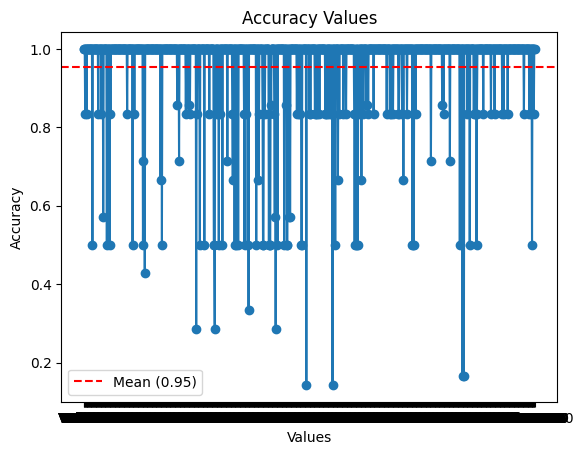

In [174]:
fig, ax = plt.subplots()
x = range(count)
ax.plot(x, acc, marker='o', linestyle='-')
ax.axhline(mean, color='r', linestyle='--', label=f'Mean ({mean:.2f})')
ax.set_xticks(x)
ax.set_xticklabels([f'Value {i+1}' for i in x])
ax.set_xlabel('Values')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Values')
ax.legend()
plt.show()

In [178]:
plt.figure(figsize=(8, 6))
plt.plot(model.fit['accuracy'], label='Training Accuracy')
plt.plot(model.fit['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

TypeError: 'method' object is not subscriptable

<Figure size 800x600 with 0 Axes>

In [156]:
sample = load_data(tf.convert_to_tensor('/home/shashank/data/s1/bbaf2n.mpg'))

In [157]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [158]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 435ms/step


In [159]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [160]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

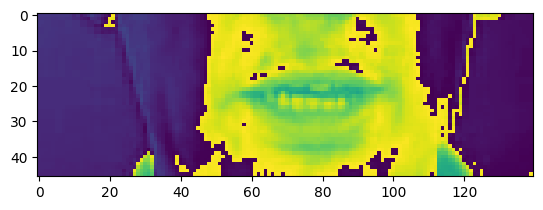

In [162]:
sample = load_data(tf.convert_to_tensor('/home/shashank/data/s1/bbaf2n.mpg'))
sample[0]
plt.imshow(sample[0][50])